In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install tensorflow nltk gensim sklearn transformers

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import warnings
import os

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input, Lambda, Embedding, GRU, Bidirectional, Concatenate, Dense
)
import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
nltk.download('punkt')
import gensim.downloader
import re
from calendar import day_name, day_abbr, month_name, month_abbr

from transformers import BertTokenizer

from collections import Counter

from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/chrico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/chrico/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
%%time

# download our pretrained word embedding with embedding size of 300
EMBED_SIZE = 300
gn300 = gensim.downloader.load('word2vec-google-news-300')

# """
# Condense our pretrained word embedding using the following two techniques:
# 1) remove stopwords
# 2) make all keys lowercase, group by key, and take average per key.
# E.g. (gn300['beyonce'] +
#       gn300['Beyonce'] +
#       gn300['BEYONCE']) / 3 -> gn300['beyonce']
# """
# S = Counter() # vector sum
# C = Counter() # vector count
# for word in gn300.vocab:
#     lower = word.lower()
#     if lower in stopwords: continue
#     S[lower] += gn300[word]
#     C[lower] += 1
# # create condensed word2vec (just a simple dictionary)
# gn300 = {w: s / c for w, s, c in zip(S.keys(), S.values(), C.values())}

CPU times: user 41.5 s, sys: 1.64 s, total: 43.2 s
Wall time: 43.2 s


In [5]:
# constants that will be used as tokens
PAD = '~PAD~'
URL = '~URL~'
DATETIME = '~DATETIME~'
QUANTITY = '~QUANTITY~'
NUM = '~NUM~'
UNK = '~UNK~'

# regexes to be applied prior to tokenization
url_regex = '(www\.|http://|https://)\S+|\S+\.(co|org|net|info|be|gov|edu|html|jpg|jpeg|png|gif)'
date_regex = '('        + '|'.join(day_name[i] for i in range(7)) +\
             '|'        + '|'.join(day_abbr[i] for i in range(7)) +\
             ')?,?\s?(' + '|'.join(month_name[i] for i in range(1, 13)) +\
             '|'        + '|'.join(month_abbr[i] for i in range(1, 13)) +\
             ")\s\d{1,2}(st|nd|rd|th)?(,?\s'?\d{2,4})?"
time_regex = '((\d+\:\d+)(\s?[AaPp]\.\s?[Mm]\.)?)|((\d+\:\d+\s?)?([AaPp]\.\s?[Mm]\.))'
quantity_regex = '\d+((\,?\d+)+)?'

# list of stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
### HYPERPARAMETERS ###
PERCENT_TEST = 0.075
PERCENT_VAL  = 0.075
MAX_TEXT_LEN = 512
MAX_TITLE_LEN = 40
TEXT_UNITS = 64
TITLE_UNITS = 5
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 2e-3
DROPOUT = 0.2
OPTIMIZER = tf.keras.optimizers.Nadam
PLATEAU_FACTOR = 0.63

val_split = PERCENT_VAL / (1 - PERCENT_TEST)
optimizer = OPTIMIZER(learning_rate=LEARNING_RATE)

checkpoint_filepath = '/tmp/checkpoint_v0'

### RANDOM SEED (for reproducibility) ###
SEED = 42
np.random.seed (SEED)
seed = SEED

In [7]:
def strip_all_duplicates(df):
    r = pd.DataFrame()
    for column in ['title', 'text']:
        c = df[column]
        flag = c.isin(c[c.duplicated()])
        r = pd.concat([r, df.loc[flag]])
    r = r.drop_duplicates()
    return df[~df.index.isin(r.index)], r

def get_real_fake(df):
    real = df[df.label.isin([0, 'REAL'])]
    fake = df[df.label.isin([1, 'FAKE'])]
    return real, fake

def split_df(df):
    global seed
    train, test = train_test_split(df, test_size=PERCENT_TEST, random_state=seed)
    seed += 1
    train, val  = train_test_split(train, test_size=val_split, random_state=seed)
    seed += 1
    return train, val, test

def concat_and_shuffle(dfs):
    global seed
    df = pd.concat(dfs)
    df = df.sample(frac=1, random_state=seed)
    seed += 1
    return df

In [8]:
# get data
if not os.path.exists('news.csv'):
    !unzip 'news.csv.zip'
df = pd.read_csv('news.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.drop_duplicates()
print (len(df), len(pd.read_csv('news.csv')) - len(df))
df, _ = strip_all_duplicates(df)
df

6306 29


,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [9]:
real, fake = get_real_fake(df)

real_train, real_val, real_test = split_df(real)
fake_train, fake_val, fake_test = split_df(fake)

# def split_by_author(df):
#     # take counts grouped by author
#     author = df.author.value_counts()
#     # split authors into groups
#     author_train, author_val, author_test = split_df(author)
#     # split data by author group
#     train = df[df.author.isin(author_train.index)].copy(deep=True)
#     val   = df[df.author.isin(author_val.index)].copy(deep=True)
#     test  = df[df.author.isin(author_test.index)].copy(deep=True)
#     return train, val, test

# real_train, real_val, real_test = split_by_author(real)
# fake_train, fake_val, fake_test = split_by_author(fake)

# real_author_counts = real.author.value_counts()
# fake_author_counts = fake.author.value_counts()
# mixed_authors = real_author_counts.index.intersection(fake_author_counts.index)
# real_author_counts[mixed_authors], fake_author_counts[mixed_authors]

In [10]:
train = concat_and_shuffle([real_train, fake_train])
val   = concat_and_shuffle([real_val, fake_val])
test  = concat_and_shuffle([real_test, fake_test])

# Expected result of val_split. This is just to give us a
# sense of the distribution of labels.
def display_count(df):
    print (len(df[df.label.isin([0, 'REAL'])]),
           len(df[df.label.isin([1, 'FAKE'])]))
display_count (train)
display_count (val)
display_count (test)

2516 2517
222 223
222 223


In [11]:
# def supertokenize(text):
#     # e.g. split_by_case('ILoveNewYork') == ['I', 'Love', 'New', 'York']
#     def split_by_case(s):
#         if (not s[1:].isupper()) and (not s[1:].islower()):
#             for i in range(1, len(s) - 1):
#                 if s[i].isupper():
#                     return [s[:i]] + split_by_case(s[i:])
#                 elif s[i + 1].isupper():
#                     return [s[:i + 1]] + split_by_case(s[i + 1:])
#         return [s]
#     text = re.sub(quantity_regex, QUANTITY, 
#                  re.sub(time_regex, DATETIME, 
#                         re.sub(date_regex, DATETIME, 
#                                re.sub(url_regex, URL, text))))
#     text = text.replace('•', '')
#     raw_tokens = nltk.word_tokenize(text)
#     tokens = []
#     for t in raw_tokens:
#         if t in '!"\'(),--./:;<?[\\]{|}“”‘’—': continue
#         if t.lower() != "n't": t = re.sub('[\"\']', '', t)
#         if (len(t) > 2) and (t.lower() == t) and (t[-1] == '.'): t = t[:-1]
#         if t == URL:
#             tokens.append (URL)
#             continue
#         if (t == DATETIME) or (re.sub('^\d+(/\d+)+$', '', t) == ''):
#             tokens.append (DATETIME)
#             continue
#         if t == QUANTITY:
#             tokens.append (QUANTITY)
#             continue
#         if t.isnumeric() or (t[:-2].isnumeric() and (
#             t[-2:] in ['st', 'nd', 'rd', 'th'])):
#             tokens.append (NUM)
#             continue
#         t = t.lower()
#         if t in stopwords: continue
#         if t in gn300:
#             tokens.append (t)
#         else:
#             if t + '.' in gn300:
#                 tokens.append (t + '.')
#                 continue
#             if t.replace('.', '') in gn300:
#                 tokens.append (t.replace('.', ''))
#                 continue
#             is_found = False
#             for x in split_by_case(re.sub('[^a-z]', '', t)):
#                 if x in gn300:
#                     tokens.append (x)
#                     is_found = True
#             if is_found: continue
#             for st in re.split('-', re.sub('[^a-z0-9\.~]', '-', t)):
#                 for x in [st, st[:-1], st[1:], st.replace('s', 'z'), 
#                           st.replace('ou', 'o'), st.replace('re', 'er')]:
#                     if x in gn300:
#                         tokens.append (x)
#                         is_found = True
#                         break
#             if not is_found: tokens.append (UNK)
#     return tokens
# TOKENIZE_FN = supertokenize
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_tokenize = lambda txt: bert_tokenizer.decode(bert_tokenizer.encode(txt))
# TOKENIZE_FN = bert_tokenize
TOKENIZE_FN = nltk.word_tokenize

In [12]:
# this does tokenization as well as tracking token counts grouped by label
def tokenize_and_update_word_counts(text, label, tokenize_fn):
    global tc_real, tc_fake
    tokens = tokenize_fn(text)
    tc = Counter(tokens)
    if label in [0, 'REAL']:
        tc_fake += tc
    elif label in [1, 'FAKE']:
        tc_real += tc
    else:
        warnings.warn('Unexpected label %s'.format(label))
    return tokens

def TERM_FREQ_FN(a, b):
    return abs(a - b) / np.sqrt(a + b)

In [13]:
%%time

tc_real = Counter()
tc_fake = Counter()

train['tokenized_title'] = train.apply(
    lambda x, y: tokenize_and_update_word_counts(
        x.title, x.label, y), axis=1, args=(TOKENIZE_FN,))
train['tokenized_text'] = train.apply(
    lambda x, y: tokenize_and_update_word_counts(
        x.text, x.label, y), axis=1, args=(TOKENIZE_FN,))

T = Counter()
for k in tc_real + tc_fake:
    T[k] = TERM_FREQ_FN(tc_real[k], tc_fake[k])

thresh = T.most_common(25000)[-1][1]
tokens = [k for k, v in T.items() if v >= thresh]

vocab, i = {PAD: 0, URL: 1, DATETIME: 2, QUANTITY: 3, NUM: 4, UNK: 5}, 6
for w in tokens:
    if w in (PAD, URL, DATETIME, QUANTITY, NUM, UNK): continue
    vocab[w] = i
    i += 1
id2word = {v: k for k, v in vocab.items()}

i, T.most_common(10)

CPU times: user 43.2 s, sys: 257 ms, total: 43.4 s
Wall time: 43.4 s


(34808,
 [("''", 97.7829389051427),
  ('``', 96.31319114069542),
  ("'s", 95.57467706163249),
  ('said', 85.235463653618),
  ('.', 80.94643585404079),
  (',', 79.21328629016182),
  ('he', 72.61887101094638),
  ('a', 68.43106620918628),
  ('the', 62.89938200692574),
  ('his', 60.56906441510858)])

In [14]:
%%time
val['tokenized_title']  = val.apply(lambda x: TOKENIZE_FN(x.title), axis=1)
val['tokenized_text']   = val.apply(lambda x: TOKENIZE_FN(x.text), axis=1)
test['tokenized_title'] = test.apply(lambda x: TOKENIZE_FN(x.title), axis=1)
test['tokenized_text']  = test.apply(lambda x: TOKENIZE_FN(x.text), axis=1)

CPU times: user 5.58 s, sys: 37.8 ms, total: 5.62 s
Wall time: 5.62 s


In [15]:
def clean(text,length):
    f = [vocab[w] if w in vocab else vocab[UNK] for w in text]
    f = f[:length]
    return (length - len(f)) * [vocab[PAD]] + f
train['text_as_ints']  = train.tokenized_text.apply(clean, args=[MAX_TEXT_LEN])
train['title_as_ints'] = train.tokenized_text.apply(clean, args=[MAX_TITLE_LEN])
val['text_as_ints']    = val.tokenized_text.apply(clean, args=[MAX_TEXT_LEN])
val['title_as_ints']   = val.tokenized_text.apply(clean, args=[MAX_TITLE_LEN])
test['text_as_ints']   = test.tokenized_text.apply(clean, args=[MAX_TEXT_LEN])
test['title_as_ints']  = test.tokenized_text.apply(clean, args=[MAX_TITLE_LEN])

In [16]:
X_train = [np.array(train.text_as_ints.to_list()),
           np.array(train.title_as_ints.to_list())]
X_val   = [np.array(val.text_as_ints.to_list()),
           np.array(val.title_as_ints.to_list())]
X_test  = [np.array(test.text_as_ints.to_list()),
           np.array(test.title_as_ints.to_list())]

# binarize labels
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(train.label)
y_val = lb.fit_transform(val.label)
y_test = lb.fit_transform(test.label)

# compute class weights based on training labels
class_weights = class_weight.compute_class_weight(
    'balanced', classes=[0, 1], y=[w for x in y_train for w in x])
class_weights = {i: weight for i, weight in enumerate(class_weights)}

In [17]:
def generate_embedding():
    emb = np.zeros((len(vocab), EMBED_SIZE))
    v = np.random.uniform(-1, 1, EMBED_SIZE)
    for i in range(len(vocab)):
        try:
            g = gn300[id2word[i]]
            emb[i] = g + v * np.linalg.norm(g) / np.linalg.norm(v)
        except KeyError:
            pass
    return Embedding(input_dim=emb.shape[0],
                     output_dim=emb.shape[1],
                     weights=[emb],
                     trainable=False)
gru = lambda units: GRU(units, dropout=DROPOUT, recurrent_dropout=DROPOUT)
mask = Lambda(lambda inputs: K.not_equal(inputs, 0))

In [18]:
input_text = Input(shape=[None])
emb_text = generate_embedding()(input_text)
gru_text = Bidirectional(gru(TEXT_UNITS))(emb_text, mask=mask(input_text))

input_title = Input(shape=[None])
emb_title = generate_embedding()(input_title)
gru_title = gru(TITLE_UNITS)(emb_title, mask=mask(input_title))

concat = Concatenate()([gru_text, gru_title])
output = Dense(1, activation='sigmoid')(concat)
model = tf.keras.Model(inputs=[input_text, input_title], outputs=output)

def run_model():
    model.summary ()
    model.compile (loss='binary_crossentropy',
                   optimizer=optimizer,
                   metrics='accuracy')
    model.fit (X_train, y_train,
               batch_size=BATCH_SIZE,
               class_weight=class_weights,
               validation_data=(X_val, y_val),
               epochs=EPOCHS,
               callbacks=[
                   tf.keras.callbacks.ModelCheckpoint(
                       filepath=checkpoint_filepath,
                       monitor='val_accuracy',
                       save_weights_only=True,
                       save_best_only=True),
                   tf.keras.callbacks.ReduceLROnPlateau(
                       factor=PLATEAU_FACTOR,
                       patience=2,
                       cooldown=1,
                       verbose=1)]
    )
    model.load_weights (checkpoint_filepath)

In [19]:
run_model ()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    10442400    input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]         

In [20]:
for i in range(len(model.layers)):
    model.layers[i].trainable = True

In [21]:
run_model ()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    10442400    input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]         

In [22]:
model.evaluate (X_test, y_test)

logits = model.predict(X_test)
y_pred = np.round(logits)

print (matthews_corrcoef(y_test, y_pred))
print (confusion_matrix(y_test, y_pred))

most_off = np.argmax(np.abs(y_test - logits))
print (y_test[most_off], logits[most_off])
test.iloc[most_off].title, test.iloc[most_off].text

14/14 [==============================] - 1s 65ms/step - loss: 0.0996 - accuracy: 0.9708
0.941582838443825
[[216   7]
 [  6 216]]
[1] [0.00148377]


('DR. MANNY: Water crisis in Flint is just the tip of the iceberg',
 "The water crisis in Flint, Mich., is just the tip of the iceberg – and if you think that it can’t happen in your community, you’re sadly mistaken. The aging water infrastructure in this country is deeply flawed. Many of the 150,000 public water systems that serve more than 300 million people are based on rusting, leaky pipes and decades-old plans that— if not corrected and replaced— will have devastating and long-lasting effects on our communities.\n\nThe disaster in Flint, which began in 2014 when the city switched its water supply from Detroit’s system to the Flint River in a cost-saving measure, is likely brewing in many other communities. It is inconceivable to me that in the most developed nation on the planet, we have exposed families and young children to the poisonous effects of lead. And it is almost criminal to me that water supply officials were unaware that the water pumping through a large American city 

In [23]:
def get_reshaped_weights(model,layer_id):
    W = np.array(model.layers[layer_id].get_weights())
    W = W.reshape(W.shape[1], W.shape[2])
    return W
text_embed = get_reshaped_weights(model,2)
title_embed = get_reshaped_weights(model,4)

<ipython-input-24-f883d067f1c4>:8: RuntimeWarning: invalid value encountered in true_divide
  cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
<ipython-input-24-f883d067f1c4>:4: RuntimeWarning: invalid value encountered in greater_equal
  n_ = np.sum(arr >= thresh)


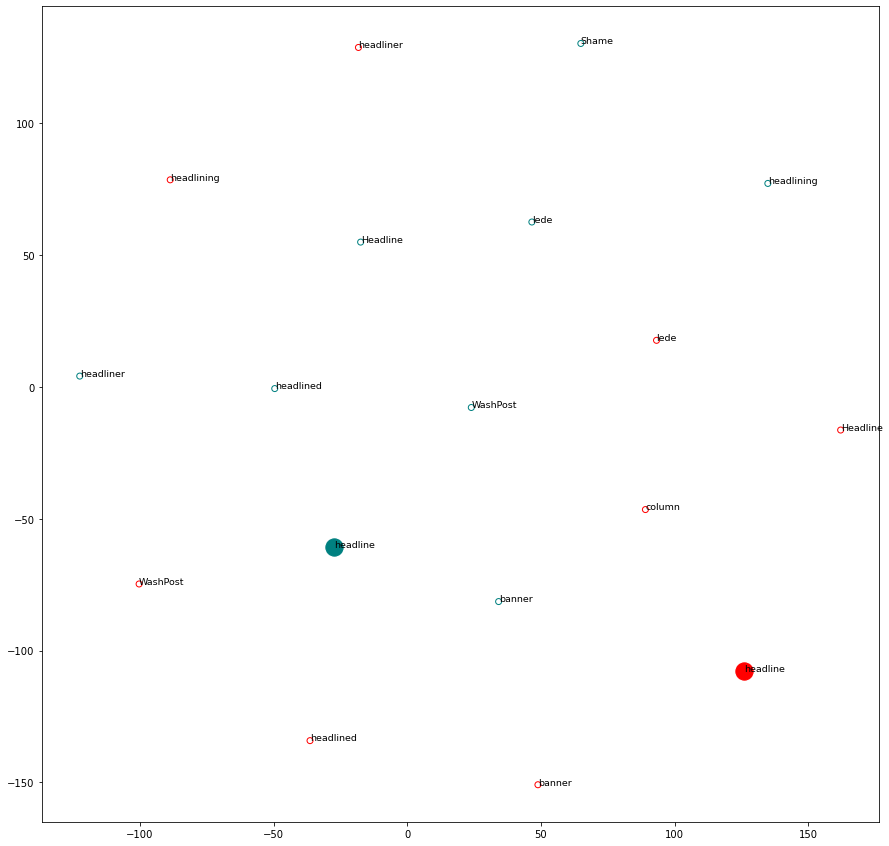

In [24]:
def get_top_n_plus_ties(arr, n):
    sorted_args = np.argsort(-arr)
    thresh = arr[sorted_args[n]]
    n_ = np.sum(arr >= thresh)
    return sorted_args[:n_]
def get_most_similar(word, W, n):
    b = W[vocab[word]]
    cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
    return get_top_n_plus_ties(cs, n)
def create_words_plot(embed1, embed2, WORD, k=9):
    ids1 = get_most_similar(WORD, embed1, k - 1)
    ids2 = get_most_similar(WORD, embed2, k - 1)
    words1 = [id2word[i] for i in ids1]
    words2 = [id2word[i] for i in ids2]
    v = TSNE(n_components=2, random_state=SEED).fit_transform(
        np.concatenate([embed1[ids1], embed2[ids2]]))
    plt.figure (figsize=(15,15))
    plt.scatter (v[:k,0], v[:k, 1], facecolors='none', edgecolors='teal')
    plt.scatter (v[k:,0], v[k:, 1], facecolors='none', edgecolors='red')
    for i, word in enumerate(words1):
        plt.annotate (word, (v[i, 0], v[i, 1]), size=9.5)
        if word == WORD:
            plt.scatter (v[i, 0], v[i, 1], c='teal', s=300)
    for i, word in enumerate(words2):
        plt.annotate (word, (v[i + k, 0], v[i + k, 1]), size=9.5)
        if word == WORD:
            plt.scatter (v[i + k, 0], v[i + k, 1], c='red', s=300)
create_words_plot (text_embed, title_embed, 'headline')